In [2]:
import pandas as pd
from rbm_torch.utils import data_prep as dp
from rbm_torch.utils.utils import fasta_read
import rbm_torch.analysis.analysis_methods as am
from rbm_torch.utils.seq_utils import prune_similar_sequences

/home/jonah/anaconda3/envs/aptamer/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
exo_df = am.fetch_data(["r2", "r3", "r4", "r5"], dir="./exo/", threads=6, molecule="dna")
exo_ct = dp.copynum_topology_faster(exo_df, ["r2", "r3", "r4", "r5"])
exo_ct.to_csv("./exo/exo_ct.csv", index=False)

In [4]:
exo_df = am.fetch_data(["r1", "r2", "r3", "r4", "r5"], dir="./exo/raw_rounds/", threads=6, molecule="dna")

Process Time 3.71872615814209
Process Time 0.5499334335327148
Process Time 0.3098418712615967
Process Time 0.18094515800476074
Process Time 0.11409568786621094


In [5]:
rpm_dict = {}  # normalize counts to reads per million (added option in fasta_read to do this automatically)
for r in ["r1", "r2", "r3", "r4", "r5"]:
    round_data = exo_df[exo_df["round"] == r]
    rpm_dict[r] = round_data["copy_num"].sum()/1000000

In [1]:
rpm_dict

NameError: name 'rpm_dict' is not defined

In [6]:
import pandas as pd
import numpy as np
exo_pd = pd.read_csv("./exo/exo_ct.csv")

# normalize counts
for r in ["r2", "r3", "r4", "r5"]:
    exo_pd[r] = exo_pd[r].div(rpm_dict[r])

# exo_pd["mean"] = exo_pd.apply(lambda row : np.nanmean(np.asarray([row[x] for x in ["r2", "r3", "r4", "r5"]])), axis=1)
# exo_pd["max"] = exo_pd.apply(lambda row : np.nanmax(np.asarray([row[x] for x in ["r2", "r3", "r4", "r5"]])), axis=1)


# def fold(dataframe, cols):
#     """ create fold column as col2/col1 for all columns"""
#     for cid, col in enumerate(cols):
#         for did, dol in enumerate(cols):
#             if cid >= did:
#                 continue
#             else:
#                 dataframe[f"{dol}/{col}_fold"] = dataframe.apply(lambda row: row[dol]/row[col] if row[col] != np.nan and row[dol] != np.nan else np.nan, axis=1)
#
#     return dataframe

# exo_pd = fold(exo_pd, ["r2", "r3", "r4", "r5"])

def enrichment_averge(df, round_names, min_diff=1, max_diff=None, diff_weights=None, round_weights=None):
    round_number = len(round_names)

    if max_diff is None:
        max_diff = round_number-1

    if diff_weights is None:
        diff_weights = [1. for x in range(min_diff, max_diff+1)]

    if round_weights is None:
        round_weights = [1. for x in range(len(round_names))]

    # first let's remove all the nan values in the dataframe, set nan values as the minimum normalized count for each round
    for r in round_names:
        df[r] = df[r].fillna(df[r].min())

    # Get fold value for round differences
    fold_keys = {diff: [] for diff in range(min_diff, max_diff+1)}
    for i in range(round_number):
        for j in range(round_number):
            if i >= j or j - i < min_diff or j - i > max_diff:
                continue
            fold_column_name = f"fold_{round_names[j]}v{round_names[i]}"
            fold_keys[j-i].append(fold_column_name)
            # fold_diffs.append(j-i)
            df[fold_column_name] = df[round_names[j]]/df[round_names[i]] * (round_weights[j] + round_weights[i])

    diff_keys = []
    for i in range(min_diff, max_diff+1):
        diff_avg_key = f"fold_diff{i}_avg"
        df[diff_avg_key] = df[fold_keys[i]].sum(axis=1).div(len(fold_keys[i])).mul(diff_weights[i-1])
        diff_keys.append(diff_avg_key)

    df["Final_Fold_Avg"] = df[diff_keys].sum(axis=1).div(len(diff_keys))

    return df

exo_pd = enrichment_averge(exo_pd, ["r2", "r3", "r4", "r5"], min_diff=1, max_diff=None, diff_weights=[0.95, 1.0, 1.0], round_weights=[0.11, 0.12,  0.13, 0.14])


In [8]:
exo_pd.head()

,sequence,r2,r3,r4,r5,fold_r3vr2,fold_r4vr2,fold_r5vr2,fold_r4vr3,fold_r5vr3,fold_r5vr4,fold_diff1_avg,fold_diff2_avg,fold_diff3_avg,Final_Fold_Avg
0,TGCGGGGCAATTTGAACACACCCGCAATCCCAGTTTGA,3.465951,2.958446,0.098298,0.117744,0.196322,0.006807,0.008493,0.008307,0.010348,0.323414,0.167214,0.008577,0.008493,0.061428
1,ATGGATCACAAGGTGTTTCTGTTTTTTTTGGGGTAA--,0.108311,0.095434,0.098298,0.235487,0.202655,0.217812,0.543545,0.257502,0.641563,0.646828,0.350545,0.429687,0.543545,0.441259
2,TTTGAACGTCCGCAGCTGCAATCGGGCGCTTAGCCA--,2.057908,1.240639,0.098298,0.117744,0.138659,0.011464,0.014304,0.019808,0.024675,0.323414,0.152596,0.018070,0.014304,0.061656
3,TGACGTAGTGACTGGATCTACACATTTTTCTTACT---,1.191421,0.477169,0.098298,0.117744,0.092116,0.019801,0.024707,0.051500,0.064156,0.323414,0.147893,0.041979,0.024707,0.071526
4,ATTAAGTTGGTAGCCGCCACCATGTTTGTCAGATC---,0.974799,0.381735,4.718280,0.117744,0.090069,1.161663,0.030197,3.090023,0.080195,0.006738,1.009163,0.620929,0.030197,0.553430


In [13]:
from copy import copy
def exclusive_rows(key_pd, query_pd, col_val):
    """returns rows in key pd that are not in query pd"""
    df_all = key_pd.merge(query_pd.drop_duplicates(), on=col_val, how='left', indicator=True)
    df_subset = copy(df_all[df_all['_merge'] == 'left_only'])
    return df_subset.drop("_merge", axis=1)

In [20]:
r1_data = exo_df[exo_df["round"] == "r1"]
r2_data = exo_df[exo_df["round"] == "r2"]
r3_data = exo_df[exo_df["round"] == "r3"]
r4_data = exo_df[exo_df["round"] == "r4"]
r5_data = exo_df[exo_df["round"] == "r5"]

In [17]:
r2_only = exclusive_rows(r2_data, exo_pd, "sequence")
r2_only.index.__len__()

In [19]:
r3_only = exclusive_rows(r3_data, exo_pd, "sequence")
r3_only.index.__len__()

116806

In [22]:
r4_only = exclusive_rows(r4_data, exo_pd, "sequence")
r4_only.index.__len__()

56685

In [24]:
r5_only = exclusive_rows(r5_data, exo_pd, "sequence")
r5_only.index.__len__()

38872

In [26]:
r2_sample = r2_only.sample(100000)
r3_sample = r3_only.sample(100000)
# r4_sample = r4_only.sample(50000)

r2_good_dists = prune_similar_sequences_df(r2_sample, exo_pd, hamming_threshold=2, return_min_distances=True)
r3_good_dists = prune_similar_sequences_df(r3_sample, exo_pd, hamming_threshold=2, return_min_distances=True)

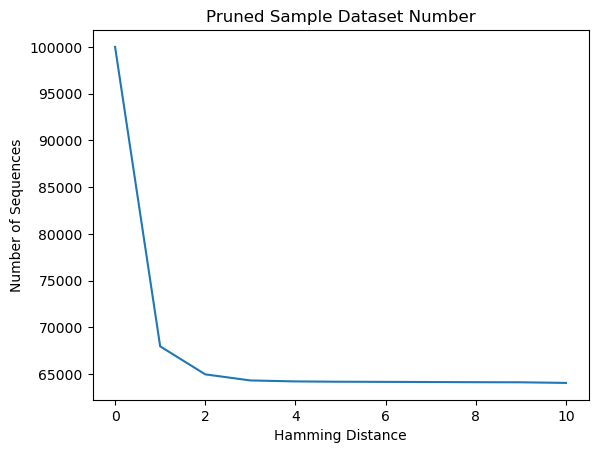

In [27]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
hamming_dists = np.arange(0, 11, 1).tolist()
number_of_seqs =[sum(i > d for i in r2_good_dists) for d in hamming_dists]
axs.plot(hamming_dists, number_of_seqs)
axs.set_xlabel("Hamming Distance")
axs.set_ylabel("Number of Sequences")
axs.set_title("Pruned Sample Dataset Number")
plt.show()

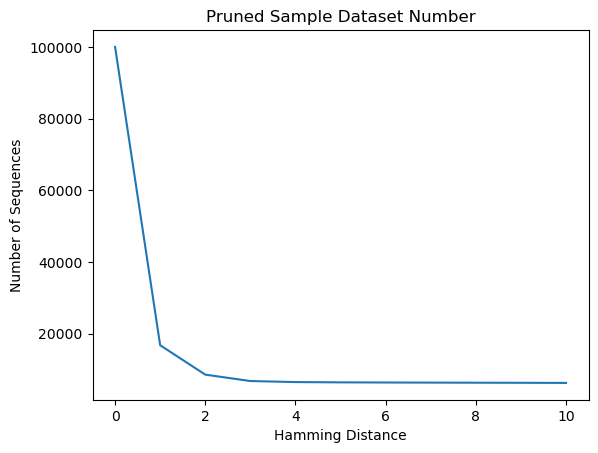

In [28]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 1)
hamming_dists = np.arange(0, 11, 1).tolist()
number_of_seqs =[sum(i > d for i in r3_good_dists) for d in hamming_dists]
axs.plot(hamming_dists, number_of_seqs)
axs.set_xlabel("Hamming Distance")
axs.set_ylabel("Number of Sequences")
axs.set_title("Pruned Sample Dataset Number")
plt.show()

In [29]:
# save 50000 seqs with no
r2_sample["fitness_value"] = [0.0001 for i in range(100000)]

r2_keep = np.asarray(r2_good_dists) > 2
r2_select = r2_sample.iloc[r2_keep, :]
r2_select.reset_index(drop=True, inplace=True)

keep_r2 = r2_select.iloc[:50000, :]

dp.dataframe_to_fasta(keep_r2, "./exo/bad_sample.fasta", count_key="fitness_value")

# r7_keep = np.asarray(r7_good_dists) > 1
# r7_select = r7_sample.iloc[r7_keep, :]
# r7_select.reset_index(drop=True, inplace=True)
#
# keep_r7 = r7_select.iloc[:75000, :]

# dp.dataframe_to_fasta(keep_r7, "./exo/mid_sample.fasta", count_key="fitness_value")


In [25]:
from rbm_torch.utils.seq_utils import seq_to_cat
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import pairwise_distances_chunked
import numpy as np

def prune_similar_sequences_df(df1, df2, hamming_threshold=0, molecule="protein", return_min_distances=False):
    """generate subset of sequences in df1 that are at least x mutations away from all sequences in df2"""
    df1.reset_index(drop=True, inplace=True)
    df1_seqs = df1["sequence"].tolist()
    df1_index = df1.index.tolist()

    df1_cat = seq_to_cat(df1_seqs, molecule=molecule)
    X = df1_cat.numpy().astype(np.int8)

    df2.reset_index(drop=True, inplace=True)
    df2_seqs = df2["sequence"].tolist()
    df2_index = df2.index.tolist()

    df2_cat = seq_to_cat(df2_seqs, molecule=molecule)
    Y = df2_cat.numpy().astype(np.int8)

    seq_len = len(df1_seqs[0])


    def reduce_func(D_chunk, start):
        # print(D_chunk)
        return np.asarray(D_chunk).min(1).tolist()

    min_distances_chunked = pairwise_distances_chunked(X, Y, reduce_func=reduce_func, metric="hamming")

    mdists = []
    for n1 in min_distances_chunked:
        mdists += n1

    if return_min_distances:
        return [x* seq_len for x in mdists]
    else:
        keep = np.asarray(mdists)*seq_len > hamming_threshold

        dataframe = df1.iloc[keep, :]

        print(f"Kept {dataframe.index.__len__()} of {df1.index.__len__()} in df1")

        dataframe.reset_index(drop=True, inplace=True)
        return dataframe

In [16]:
from copy import copy
df_all = exo_df.merge(exo_pd, on="sequence", how='left', indicator=True)
single_round_seqs = copy(df_all[df_all['_merge'] == 'left_only'])
single_round_seqs.index.__len__()
background_seqs = copy(single_round_seqs[single_round_seqs['copy_num'] > 5])
background_seqs["Fitness_Value"] = list(np.full((background_seqs.index.__len__()), 0.001))
dp.dataframe_to_fasta(background_seqs, "./exo/background.fasta", count_key="Fitness_Value")

In [ ]:
exo_pd["Fitness_Value"] = dp.scale_values_np(dp.log_scale(exo_pd["Final_Fold_Avg"].tolist(), base=1.0), min=0.01, max=1.0)

exo_pd.sort_values("Fitness_Value", ascending=False, inplace=True)
dp.dataframe_to_fasta(exo_pd, "./exo/fold_avg_all3.fasta", count_key="Fitness_Value")

In [ ]:
enriched_exo.sort_values("Final_Fold_Avg", ascending=False, inplace=True)
exo_enriched_pruned = prune_similar_sequences(enriched_exo, hamming_threshold=2, molecule="dna")

In [ ]:
exo_enriched_pruned = copy(exo_enriched_pruned)
exo_enriched_pruned["Fitness_Value"] = dp.scale_values_np(dp.log_scale(exo_enriched_pruned["Final_Fold_Avg"].tolist(), base=1.0), min=0.1, max=1.0)
dp.dataframe_to_fasta(exo_enriched_pruned, "./exo/enriched_trimmed.fasta", count_key="Fitness_Value")

In [ ]:
exo_pd[exo_pd["Final_Fold_Avg"] > 1].index.__len__()

In [ ]:
from copy import copy
enriched_exo = copy(exo_pd[exo_pd["Final_Fold_Avg"] > 1])

enriched_exo["Fitness_Value"] = dp.scale_values_np(dp.log_scale(enriched_exo["fold_r5vr2"].tolist(), base=1.0), min=0.1, max=1.0)

enriched_exo.sort_values("Fitness_Value", ascending=False, inplace=True)
dp.dataframe_to_fasta(enriched_exo, "./exo/enriched.fasta", count_key="Fitness_Value")

In [ ]:
from copy import copy
single_fold_exo = copy(exo_pd)

single_fold_exo["Fitness_Value"] = dp.scale_values_np(dp.log_scale(single_fold_exo["fold_r5vr2"].tolist(), base=1.0), min=0.01, max=1.0)

single_fold_exo.sort_values("Fitness_Value", ascending=False, inplace=True)
dp.dataframe_to_fasta(single_fold_exo, "./exo/fold_r5vr2.fasta", count_key="Fitness_Value")

In [ ]:
exo_pd.head()

In [24]:
enriched_exo.sort_values("Final_Fold_Avg", ascending=False, inplace=True)
exo_enriched_pruned = prune_similar_sequences(enriched_exo, hamming_threshold=2, molecule="dna")

Kept 9956 of 12339


In [26]:
exo_enriched_pruned = copy(exo_enriched_pruned)
exo_enriched_pruned["Fitness_Value"] = dp.scale_values_np(dp.log_scale(exo_enriched_pruned["Final_Fold_Avg"].tolist(), base=1.0), min=0.1, max=1.0)
dp.dataframe_to_fasta(exo_enriched_pruned, "./exo/enriched_trimmed.fasta", count_key="Fitness_Value")

In [21]:
exo_pd[exo_pd["Final_Fold_Avg"] > 1].index.__len__()

12339

In [22]:
from copy import copy
enriched_exo = copy(exo_pd[exo_pd["Final_Fold_Avg"] > 1])

enriched_exo["Fitness_Value"] = dp.scale_values_np(dp.log_scale(enriched_exo["fold_r5vr2"].tolist(), base=1.0), min=0.1, max=1.0)

enriched_exo.sort_values("Fitness_Value", ascending=False, inplace=True)
dp.dataframe_to_fasta(enriched_exo, "./exo/enriched.fasta", count_key="Fitness_Value")

In [19]:
from copy import copy
single_fold_exo = copy(exo_pd)

single_fold_exo["Fitness_Value"] = dp.scale_values_np(dp.log_scale(single_fold_exo["fold_r5vr2"].tolist(), base=1.0), min=0.01, max=1.0)

single_fold_exo.sort_values("Fitness_Value", ascending=False, inplace=True)
dp.dataframe_to_fasta(single_fold_exo, "./exo/fold_r5vr2.fasta", count_key="Fitness_Value")

In [17]:
exo_pd.head()

,sequence,r2,r3,r4,r5,fold_r3vr2,fold_r4vr2,fold_r5vr2,fold_r4vr3,fold_r5vr3,fold_r5vr4,fold_diff1_avg,fold_diff2_avg,fold_diff3_avg,Final_Fold_Avg,Fitness_Value
222388,GGTCCTCAACCTGCGACGGAGTCCCAACATGTCCA---,0.108311,0.095434,0.196595,315185.882054,0.202655,0.435623,727502.203398,0.515004,858693.356321,4.328705e+05,137075.895715,429346.895972,727502.203398,431308.331695,1.000000
235661,TGTTACCTACGCATACCATTACGGGCCTTTGACTGTGA,0.108311,0.095434,0.196595,69177.159597,0.202655,0.435623,159672.557995,0.515004,188466.459754,9.500665e+04,30085.665515,94233.447689,159672.557995,94663.890400,0.883918
126562,GGAGCTATGCCGTGATGGGCTCTACTGTTGTTTTTA--,1.083110,0.477169,176580.854909,0.117744,0.101328,39127.527470,0.027177,92514.886024,0.064156,1.800354e-07,29296.412661,19563.795813,0.027177,16286.745217,0.749201
144680,ATCCAGCGTAGCACCCGACATCGCAACCCGTAGAAA--,1.083110,0.477169,109302.011029,14785.317826,0.101328,24219.598672,3412.700856,57265.908571,8056.232789,3.652299e-02,18134.248033,16137.915731,3412.700856,12561.621540,0.729323
21663,TTCCGACACCCTCAACGCAGGGTTGAACTTACCCCTGA,1.083110,0.477169,93698.952876,0.117744,0.101328,20762.207514,0.027177,49091.097392,0.064156,3.392867e-07,15545.546261,10381.135835,0.027177,8642.236425,0.700699


In [7]:
exo_pd.index.__len__()

242496

In [6]:
exo_pd.head()

,sequence,r2,r3,r4,r5,max,fold_r3vr2,fold_r4vr2,fold_r5vr2,fold_r4vr3,fold_r5vr3,fold_r5vr4,fold_diff1_avg,fold_diff2_avg,fold_diff3_avg,Final_Fold_Avg
0,TGCGGGGCAATTTGAACACACCCGCAATCCCAGTTTGA,3.465951,2.958446,0.098298,0.117744,3.465951,1.792506,0.060976,0.074737,0.074759,0.091538,2.814902,1.560722,0.091508,0.097159,0.583130
1,ATGGATCACAAGGTGTTTCTGTTTTTTTTGGGGTAA--,0.108311,0.095434,0.098298,0.235487,0.235487,1.850329,1.951230,4.783195,2.317517,5.675364,5.629803,3.265883,4.575956,6.218153,4.686664
2,TTTGAACGTCCGCAGCTGCAATCGGGCGCTTAGCCA--,2.057908,1.240639,0.098298,0.117744,2.057908,1.266014,0.102696,0.125874,0.178271,0.218283,2.814902,1.419729,0.192588,0.163636,0.591984
3,TGACGTAGTGACTGGATCTACACATTTTTCTTACT---,1.191421,0.477169,0.098298,0.117744,1.191421,0.841058,0.177385,0.217418,0.463503,0.567536,2.814902,1.373154,0.446953,0.282643,0.700917
4,ATTAAGTTGGTAGCCGCCACCATGTTTGTCAGATC---,0.974799,0.381735,4.718280,0.117744,4.718280,0.822368,10.406561,0.265733,27.810210,0.709420,0.058644,9.563741,6.669589,0.345453,5.526261


In [22]:
from copy import copy
enriched = copy(exo_pd[(exo_pd["r5/r4_fold"] > 2) | (exo_pd["r5/r3_fold"] > 3)])
enriched["fold"] = enriched.apply(lambda row: np.nanmax(np.asarray([row["r5/r4_fold"], row["r5/r3_fold"]])), axis=1)
print(enriched.index.__len__())

23382


In [23]:
enriched.sort_values("fold", ascending=False, inplace=True)
enriched_trimmed = prune_similar_sequences(enriched, hamming_threshold=4, molecule="dna")

Kept 20919 of 23382


In [24]:
dp.dataframe_to_fasta(enriched_trimmed, "./exo/enriched.fasta", count_key="fold")

In [25]:
seqs, folds, chars, q = fasta_read("./exo/enriched.fasta", "dna", threads=6)

Process Time 0.024022579193115234


In [36]:
std_folds = dp.standardize_affinities(folds, out_plots="./exo/enriched", scale="log", dividers=[10], target_scaling=[2.49], divider_type="percentile")

In [38]:
dp.make_weight_file("./exo/en_fold_st", std_folds)

In [18]:
top50_seqs, top50cns, chars50, q50 = dp.fasta_read("./exo/fold_avg_top50.fasta", "dna", threads=12)
v_seqs, vcns, vchars, vq = dp.fasta_read("./exo/pev_n.fasta", "dna", threads=12)
l_seqs, lcns, lchars, lq = dp.fasta_read("./exo/pev_n.fasta", "dna", threads=12)

avoid_seqs = v_seqs+l_seqs

train_set = [(x, top50cns[xid]) for xid, x in enumerate(top50_seqs) if x not in avoid_seqs ]

Process Time 0.04651784896850586
Process Time 0.0036745071411132812
Process Time 0.0025069713592529297


In [19]:
len(train_set)

49670

In [24]:
train_seqs, train_cns = list(zip(*train_set))
dp.write_fasta(train_seqs, train_cns, "./exo/caris_train.fasta")

In [22]:
train_cns

(1.0,
 0.9000297513733405,
 0.7780754141359186,
 0.7622574079643377,
 0.7363015694770522,
 0.7130464028274566,
 0.7105146831676591,
 0.6624593833236179,
 0.6472345141934827,
 0.639186000091549,
 0.6326339240624735,
 0.6307539543605172,
 0.6304063060372952,
 0.6265485045868101,
 0.6208354108769182,
 0.6182549974264525,
 0.6132541628654202,
 0.5989156506775591,
 0.5982639641013371,
 0.5872403294697864,
 0.5844197974566168,
 0.5838517819461584,
 0.5835775379629128,
 0.5834703675404612,
 0.5797468849696881,
 0.5751526829114473,
 0.5721593456225001,
 0.5629739447772547,
 0.558867946962121,
 0.5577473468870832,
 0.556709957133715,
 0.5516255359553985,
 0.5441698557429883,
 0.5408493533199272,
 0.5378691846793252,
 0.5359962262084343,
 0.5347779929709165,
 0.5339783345268935,
 0.5333611604001016,
 0.5301924004254517,
 0.5277685574314137,
 0.5272433424778459,
 0.5248938835234082,
 0.5246609335799262,
 0.5245446620441433,
 0.5226984386719387,
 0.518775378904574,
 0.5175758905695559,
 0.51692317